# CAP 4611 - Credit Card Fraud
Given a large database of transaction histories from different customers, the goal is to create a model that can accurately detect fraudulent transactions.

The data is of the following format:
1. accountNumber - Unique account number.
2. customerId - Unique id for customer.
3. creditLimit - The upper credit limit the account has.
4. availableMoney - The amount of money that the account can use.
5. transactionDateTime - The date and time that the transaction took place.
6. transactionAmount - The amount that the transaction was for.
7. merchantName - The name of business that the transaction was made at.
8. acqCountry - The country the transaction was made in.
9. merchantCountryCode - The country the merchant is based in.
10. posEntryMode - The method that the cardholder used to enter information.
11. posConditionCode - The condition of the transaction.
12. merchantCategoryCode - The type of business that the merchant is.
13. currentExpDate - The expiry date for the card.
14. accountOpenDate - The date the account was opened.
15. dateofLastAddressChange - The date the address was last altered.
16. cardCVV - The CVV of the card.
17. enteredCVV - The CVV that was entered by the cardholder.
18. cardLast4Digits - The last four digits of the card.
19. transacitonType - The type of transaction that occured.
20. **isFraud** - Whether if the transaction was fraudulent (the label).
21. echoBuffer - ??? (Unknown)
22. currentBalance - The balance that is currently on the card.
23. merchantCity - The city where the merchant resides.
24. merchantState - The state that the merchant resides.
25. merchantZip - The ZIP code for the merchant.
26. cardPresent - Whether if the card was physcially present during the transaction.
27. posOnPremises - Whether if the transaction was done at the physical merchant location.
28. recurringAuthInd - ??? (Unknown)
29. expirationDateKeyInMatch - Expired card? (Unsure)


## Step 1: Data Preparation
The first step to take is to load in the data.

In [1]:
# Modified sample code to create dataframe
# ----------------------------------------

import numpy as np
import json
import pandas as pd

# converts list of dictionary of intances into dictionary of features 
# and returns column oriented dataframe 
def load_data(data):
    parse_data=data[0].keys()
    trans_data={}
    for i in parse_data:
        trans_data[i]=list()
    for row in data:
        for keys,values in row.items():
            if values=='':
                trans_data[keys].append(float("NaN")) #missing datapoints are assigned with 'NaN'
            else:
                trans_data[keys].append(values)
    return pd.DataFrame.from_dict(trans_data)

#Opening the file
from google.colab import drive
drive.mount('/content/drive')
contents = open("/content/drive/MyDrive/transactions.txt", "r").read()  
list_dict = [json.loads(str(item)) for item in contents.strip().split('\n')]
transaction_df=load_data(list_dict)

#Transaction data Data Frame
transaction_df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,isFraud,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch
0,733493772,733493772,5000.0,5000.00,2016-01-08T19:04:50,111.33,Lyft,US,US,05,01,rideshare,04/2020,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,NaN,0.00,NaN,NaN,NaN,False,NaN,NaN,False
1,733493772,733493772,5000.0,4888.67,2016-01-09T22:32:39,24.75,Uber,US,US,09,01,rideshare,06/2023,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,NaN,111.33,NaN,NaN,NaN,False,NaN,NaN,False
2,733493772,733493772,5000.0,4863.92,2016-01-11T13:36:55,187.40,Lyft,US,US,05,01,rideshare,12/2027,2014-08-03,2014-08-03,492,492,9184,PURCHASE,False,NaN,136.08,NaN,NaN,NaN,False,NaN,NaN,False
3,733493772,733493772,5000.0,4676.52,2016-01-11T22:47:46,227.34,Lyft,US,US,02,01,rideshare,09/2029,2014-08-03,2014-08-03,492,492,9184,PURCHASE,True,NaN,323.48,NaN,NaN,NaN,False,NaN,NaN,False
4,733493772,733493772,5000.0,4449.18,2016-01-16T01:41:11,0.00,Lyft,US,US,02,01,rideshare,10/2024,2014-08-03,2014-08-03,492,492,9184,ADDRESS_VERIFICATION,False,NaN,550.82,NaN,NaN,NaN,False,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
641909,186770399,186770399,7500.0,2574.02,2016-12-04T12:29:21,5.37,Apple iTunes,US,US,05,08,mobileapps,01/2030,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,4925.98,NaN,NaN,NaN,False,NaN,NaN,False
641910,186770399,186770399,7500.0,2568.65,2016-12-09T04:20:35,223.70,Blue Mountain eCards,US,US,09,01,online_gifts,05/2026,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,4931.35,NaN,NaN,NaN,False,NaN,NaN,False
641911,186770399,186770399,7500.0,2344.95,2016-12-16T07:58:23,138.42,Fresh Flowers,US,US,02,01,online_gifts,10/2019,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,5155.05,NaN,NaN,NaN,False,NaN,NaN,False
641912,186770399,186770399,7500.0,2206.53,2016-12-19T02:30:35,16.31,abc.com,US,US,09,08,online_subscriptions,11/2029,2015-11-04,2016-06-03,127,127,5432,PURCHASE,False,NaN,5293.47,NaN,NaN,NaN,False,NaN,NaN,False


Let's get a better visual of what features are represented in this dataset.

In [2]:
print(len(transaction_df.columns))
transaction_df.dtypes

29


accountNumber                object
customerId                   object
creditLimit                 float64
availableMoney              float64
transactionDateTime          object
transactionAmount           float64
merchantName                 object
acqCountry                   object
merchantCountryCode          object
posEntryMode                 object
posConditionCode             object
merchantCategoryCode         object
currentExpDate               object
accountOpenDate              object
dateOfLastAddressChange      object
cardCVV                      object
enteredCVV                   object
cardLast4Digits              object
transactionType              object
isFraud                        bool
echoBuffer                  float64
currentBalance              float64
merchantCity                float64
merchantState               float64
merchantZip                 float64
cardPresent                    bool
posOnPremises               float64
recurringAuthInd            

Some of these categories seem to be useless to keep. Account Number, Id, and card number are merely for identification purposes, and thus can be removed entirely. Merchant Name seems like it wouldn't be that useful, but Merchant Category Code seems to be (there are far too many businesses for the models to be able to recognize the impact of specific businesses, the categories of business seems easier to use).

In [3]:
# Removes features
del transaction_df['accountNumber']
del transaction_df['customerId']
del transaction_df['cardLast4Digits']
del transaction_df['merchantName']

### Missing Data
We can see that there are 24 variables that are given to determine whether if there is fraud or not. Not all of the data exists for each transaction, however, so let's see how much each category is affect by missing data.

In [4]:
c,r = transaction_df.shape

print('Percentage of Data Available')
print('----------------------------')
for col in transaction_df.columns:
  null_data = 1.0 * sum(transaction_df[col].isnull()) / c
  print('  {0}: {1:.3f}%'.format(col,(1-null_data) * 100))

Percentage of Data Available
----------------------------
  creditLimit: 100.000%
  availableMoney: 100.000%
  transactionDateTime: 100.000%
  transactionAmount: 100.000%
  acqCountry: 99.390%
  merchantCountryCode: 99.903%
  posEntryMode: 99.479%
  posConditionCode: 99.955%
  merchantCategoryCode: 100.000%
  currentExpDate: 100.000%
  accountOpenDate: 100.000%
  dateOfLastAddressChange: 100.000%
  cardCVV: 100.000%
  enteredCVV: 100.000%
  transactionType: 99.908%
  isFraud: 100.000%
  echoBuffer: 0.000%
  currentBalance: 100.000%
  merchantCity: 0.000%
  merchantState: 0.000%
  merchantZip: 0.000%
  cardPresent: 100.000%
  posOnPremises: 0.000%
  recurringAuthInd: 0.000%
  expirationDateKeyInMatch: 100.000%


There are categories where there is no data to work with (existing data is 0%). We can just remove that data without any loss of information.

In [5]:
# Removes empty columns from dataframe
for col in transaction_df.columns:
  null_data = 1.0 * sum(transaction_df[col].isnull()) / c
  if null_data == 1:
    del transaction_df[col]

# Shows total amount of columns remaining
print(len(transaction_df.columns))

19


### Imputation
As for other missing data in the set, let's look at all the methods that had gaps.

In [6]:
# Will hold all the columns with missing data for later
missing_data = []

print('Missing data count for every non-complete feature.')
for col in transaction_df.columns:
  cnt = sum(transaction_df[col].isnull())
  null_data = 1.0 * cnt / c
  if null_data != 0:
    print('  {0}: {1}'.format(col,cnt))
    missing_data.append(col)

Missing data count for every non-complete feature.
  acqCountry: 3913
  merchantCountryCode: 624
  posEntryMode: 3345
  posConditionCode: 287
  transactionType: 589


One way to fix the gaps is imputation. Since all of the categories with missing data are categorical, let's use the mode of each column to fill in the gaps.

In [7]:
# fills in data with the mode of each respective column
for feature in missing_data:
  transaction_df[feature].fillna(transaction_df[feature].mode()[0],inplace=True)

# Checks to make sure there are no more missing values
print('Missing data count for every non-complete feature.')
for feature in missing_data:
  cnt = sum(transaction_df[feature].isnull())
  print('  {0}: {1}'.format(feature,cnt))

Missing data count for every non-complete feature.
  acqCountry: 0
  merchantCountryCode: 0
  posEntryMode: 0
  posConditionCode: 0
  transactionType: 0


### Encoding Categorical Data
Now that the dataset is complete, let's alter some of the data so that the learning algorithms have an easier time understanding the 'meaning' of the data. One useful method is one-hot-encoding, which allows for categorical data to be split into binary vectors. These vectors are represented as multiple columns holding binary data. In order to limit the curse of dimensionality, let's only encode features that have less than 20 unique categories (features with a small cardinality).

In [8]:
large_features = []

# Encode features with few categories
threshold = 20
print('One-hot Encoded Features.')
for col in transaction_df:
  # Tests if data is categorical
  if transaction_df[col].dtype == object:
    # Tests how many categories are in feature
    unique_vals = len(transaction_df[col].unique())
    if unique_vals < threshold:
      # Encodes feature
      x = pd.get_dummies(transaction_df[col],prefix=col)
      # Removes non-encoded feature
      del transaction_df[col]
      # Adds encodings to the dataframe
      transaction_df = transaction_df.join(x)
      print('  {0}: {1}'.format(col, [i for i in x]))
    else:
      # saves what the large features are for later
      large_features.append(col)

One-hot Encoded Features.
  acqCountry: ['acqCountry_CAN', 'acqCountry_MEX', 'acqCountry_PR', 'acqCountry_US']
  merchantCountryCode: ['merchantCountryCode_CAN', 'merchantCountryCode_MEX', 'merchantCountryCode_PR', 'merchantCountryCode_US']
  posEntryMode: ['posEntryMode_02', 'posEntryMode_05', 'posEntryMode_09', 'posEntryMode_80', 'posEntryMode_90']
  posConditionCode: ['posConditionCode_01', 'posConditionCode_08', 'posConditionCode_99']
  merchantCategoryCode: ['merchantCategoryCode_airline', 'merchantCategoryCode_auto', 'merchantCategoryCode_cable/phone', 'merchantCategoryCode_entertainment', 'merchantCategoryCode_fastfood', 'merchantCategoryCode_food', 'merchantCategoryCode_food_delivery', 'merchantCategoryCode_fuel', 'merchantCategoryCode_furniture', 'merchantCategoryCode_gym', 'merchantCategoryCode_health', 'merchantCategoryCode_hotels', 'merchantCategoryCode_mobileapps', 'merchantCategoryCode_online_gifts', 'merchantCategoryCode_online_retail', 'merchantCategoryCode_online_subsc

Let's see what the remaining features to be encoded are:

In [9]:
print(large_features)

['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange', 'cardCVV', 'enteredCVV']


These categories may be useful when combined with other categories. Some useful ways to extrapolate useful information from these features are as follows:
* Knowing the difference in time between the transaction and accounting opening; expiration date; and address change might be useful numerical data.
* Knowing whether if there was a difference in the card CVV and the entered one also seems like a good binary indicator to have.
* Knowing the time of day (whether the transaction happened during the day or at night) might be useful.

Let's add these constructed features to the dataset.

In [10]:
import datetime

transaction_date = transaction_df['transactionDateTime'].map(lambda x: 
  datetime.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S'))

open_date = transaction_df['accountOpenDate'].map(lambda x: 
  datetime.datetime.strptime(x, '%Y-%m-%d'))
expiration_date = transaction_df['currentExpDate'].map(lambda x: 
  datetime.datetime.strptime(x, '%m/%Y')) + pd.tseries.offsets.MonthEnd()
address_change = transaction_df['dateOfLastAddressChange'].map(lambda x: 
  datetime.datetime.strptime(x, '%Y-%m-%d'))

In [11]:
# Gets differences in days between various features and adds them to dataframe

days_since_open = (transaction_date - open_date).map(lambda x: x.days)
days_before_expiration = (expiration_date - transaction_date).map(lambda x: x.days)
days_since_addr = (transaction_date - address_change).map(lambda x: x.days)

del transaction_df['accountOpenDate']
del transaction_df['currentExpDate']
del transaction_df['dateOfLastAddressChange']

transaction_df = transaction_df.merge(
    days_since_open.to_frame(name='days_since_open'),left_index=True,right_index=True)
transaction_df = transaction_df.merge(
    days_before_expiration.to_frame(name='days_before_exp'),left_index=True,right_index=True)
transaction_df = transaction_df.merge(
    days_since_addr.to_frame(name='days_since_addr'),left_index=True,right_index=True)

In [12]:
# Gets whether if there was a difference in entered CVV

isCVVDiff = transaction_df['cardCVV'].astype(int) - transaction_df['enteredCVV'].astype(int)
isCVVDiff = isCVVDiff != 0
del transaction_df['cardCVV']
del transaction_df['enteredCVV']
transaction_df = transaction_df.merge(
    isCVVDiff.to_frame(name='isCVVDiff'),left_index=True,right_index=True)

In [13]:
# Determines whether the transaction happened at night and adds it to dataframe

# Grabs the hour
isNight = transaction_df['transactionDateTime'].str.slice(11,13).astype(int)
# Considers the hours from 6pm to 6am 'night'
isNight = (isNight >= 18) | (isNight < 6)
del transaction_df['transactionDateTime']
transaction_df = transaction_df.merge(
    isNight.to_frame(name='isNight'),left_index=True,right_index=True)

The last step in preparing the data is to separate the labels (whether if there is fraud) from the features and convert them into numpy arrays.

In [14]:
labels = transaction_df['isFraud']
transaction_df.pop('isFraud')

0          True
1         False
2         False
3          True
4         False
          ...  
641909    False
641910    False
641911    False
641912    False
641913    False
Name: isFraud, Length: 641914, dtype: bool

## Step 2: Data Visualization
Now that the dataset is more prepared for learning, let's learn more about the data through some visuals.

What time of day are fraudulent transactions most likely to occur?

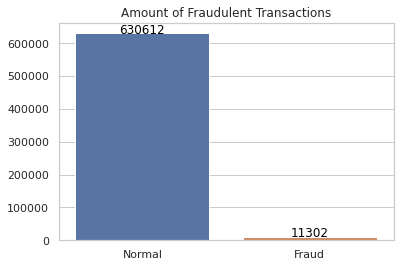

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

normal_transactions = len(labels[labels==False])
fraud_transactions = len(labels[labels==True])

ax = sns.barplot(x=["Normal","Fraud"],y=[normal_transactions,fraud_transactions])

ax.text(0,normal_transactions,normal_transactions,color='black',ha='center')
ax.text(1,fraud_transactions,fraud_transactions,color='black',ha='center')
ax.set_title('Amount of Fraudulent Transactions')

plt.show()

As to be expected, this data is heavilly unbalanced... highly favoring normal transactions over fraudulent ones. Now, let's test a hypothesis from before: out of all the fraudulent transactions, are there more that happen at a particular time of day?

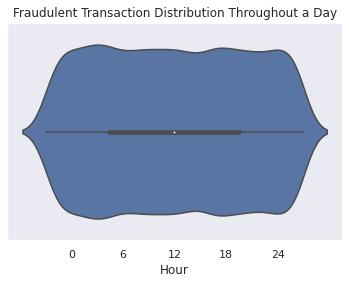

In [16]:
transaction_time = transaction_date.map(lambda x: x.hour * 3600 + 
                                        x.minute * 60 + x.second)

sns.set_style('dark')

ax = sns.violinplot(x=transaction_time.values[labels == True])

ax.set(xlabel='Hour')
ax.set_title('Fraudulent Transaction Distribution Throughout a Day')
ax.set_xticks([i*86400/5 + 8640 for i in range(5)])
ax.set_xticklabels([i*6 for i in range(5)])

plt.show()

Uh oh... it appears that time does not a major role in when credit card fraud occurs (at least from first glance). Combined with other features, perhaps the day/night difference may play some role in helping determine when a transaction is fraudulent. Thus, we will leave the data as is.

What about where fraudulent transactions took place? Let's take a look at a couple of different types of merchants and see whether if there is any difference in the amount of fraud at these places.

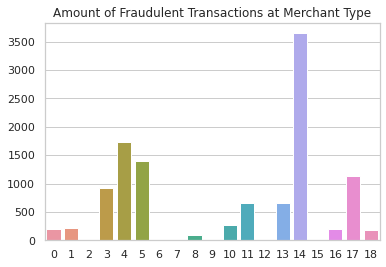

In [17]:
sns.set_theme(style="whitegrid")

# Gets all the list of merchants
merch_lst = [s for s in transaction_df.columns if "merchantCategoryCode" in s]
# Gets fraud for each merchant
merch_fraud = [sum(labels & transaction_df[s]) for s in merch_lst]

ax = sns.barplot(x=[i for i in range(len(merch_fraud))],y=merch_fraud)

ax.set_title('Amount of Fraudulent Transactions at Merchant Type')

plt.show()

Let's compare it to normal transactions at these places:

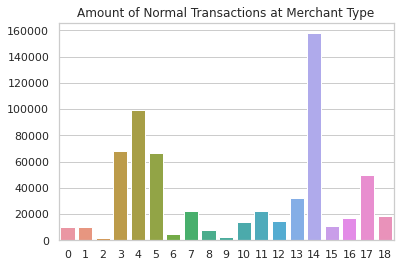

In [18]:
# Gets fraud for each merchant
merch_normal = [sum((labels==0) & transaction_df[s]) for s in merch_lst]

ax = sns.barplot(x=[i for i in range(len(merch_normal))],y=merch_normal)

ax.set_title('Amount of Normal Transactions at Merchant Type')

plt.show()

The ratio is close, and that is to be expected. Any differences however may be useful for the models to determine whether if a transaction is fraudulent or not.

## Step 3: Imbalanced Dataset
Before we test models, let's fix the imbalanced dataset issue found in the previous section. First, let's transform the dataframe into numpy arrays.

In [19]:
transaction_df_np = transaction_df.values
labels_np = labels.values

We can use a method called SMOTE to artifically balance the dataset to improve learning [1]. SMOTE tends to work better when combined with undersampling of the larger class, so we will do that here as well.

In [20]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Oversamples fraud to be 0.1 times the size of normal
over = SMOTE(sampling_strategy = 0.1)
# Undersamples normal so that fraud is 1 times the size (makes balanced)
under = RandomUnderSampler(sampling_strategy = 1)
# Transform the dataset
tdf_smote, labels_smote = over.fit_resample(transaction_df, labels_np)
tdf_smote, labels_smote = under.fit_resample(tdf_smote, labels_smote)

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/loca

Let's compare the two dataset sizes now:

In [21]:
from collections import Counter

print('Original Dataset:')
print(Counter(labels))
print('\nDataset with SMOTE and Undersampling:')
print(Counter(labels_smote))

Original Dataset:
Counter({False: 630612, True: 11302})

Dataset with SMOTE and Undersampling:
Counter({False: 63061, True: 63061})


We will use this new SMOTE dataset with the original and compare the output at the end.

## Step 4: Modeling and Cross Validation
Now, let's use the data we have and try to learn what is fraudulent and what is real. Let's test our dataset(s) on a couple of different 

### Data Split
Let's split the data into a 80/20 test-train split.

In [22]:
from sklearn.model_selection import train_test_split

# Splits the original data into training/testing sets
X_train, X_test, y_train, y_test = train_test_split(
    transaction_df_np, labels_np, test_size=0.2)

# Splits the smote data into training/testing sets
X_train_smote, X_test_smote, y_train_smote, y_test_smote = train_test_split(
    tdf_smote, labels_smote, test_size=0.2)

### Imports and Meta-parameters

In [23]:
from sklearn.model_selection import cross_val_score
from hyperopt import fmin,tpe,hp,STATUS_OK,Trials,rand

# How many iterations of Bayesian Optimization each algorithm will go through
evals = 5

### Random Forest
For the first classifier, let's try a random forest classifier on our data. This will be the classifier where we compare the imbalanced data to the balanced data, so we will run the testing twice. For all the classfiers, we're going to optimize the hyperparamters for them using Bayesian Optimization. We will use AUROC to score the models, and in the next section evaluate with F1 (the reason for not using it now is clear later) and AUROC. As for the accuracy metric, it would not be suitable because of the imbalanced dataset. We could use it on the balanced (SMOTE) dataset, but for consistency AUROC and F1 are fine.

In [24]:
from sklearn.ensemble import RandomForestClassifier

rf_trials = Trials()

# Defines the objective function
def random_forest_tuner(params):
    model = RandomForestClassifier(**params)
    # Gets auroc score from model predictions using cross validation, k=5
    # inherently makes a validation set to use
    auroc = cross_val_score(model, X_train, y_train, cv=5,
                            scoring='roc_auc').mean()
    # Minimizes function, therefore -auroc
    return {"loss": -auroc, "status": STATUS_OK}

max_features = ['log2','sqrt']
criteria = ['entropy','gini']

random_forest_space = {
    "max_features": hp.choice('max_features',max_features),
    "criterion": hp.choice('criterion', criteria),
    "max_depth": hp.choice('max_depth', np.arange(1, 12, dtype=int)),
    "n_estimators": hp.choice('n_estimators',np.arange(20,100, dtype=int))
}

rf_best = fmin(fn=random_forest_tuner,
    		space=random_forest_space,
        algo=tpe.suggest,
    		max_evals=evals,
    		trials = rf_trials)

print(rf_best)

100%|██████████| 5/5 [12:14<00:00, 146.95s/it, best loss: -0.7481598990656981]
{'criterion': 1, 'max_depth': 8, 'max_features': 1, 'n_estimators': 32}


Now for SMOTE:

In [25]:
rf_trials_smote = Trials()

# Defines the objective function
def random_forest_tuner_smote(params):
    model = RandomForestClassifier(**params)
    # Gets auroc score from model predictions using cross validation, k=5
    # inherently makes a validation set to use
    auroc = cross_val_score(model, X_train_smote, y_train_smote, cv=5,
                            scoring='roc_auc').mean()
    # Minimizes function, therefore -auroc
    return {"loss": -auroc, "status": STATUS_OK}

random_forest_space_smote = {
    "max_features": hp.choice('max_features',max_features),
    "criterion": hp.choice('criterion', criteria),
    "max_depth": hp.choice('max_depth', np.arange(1, 12, dtype=int)),
    "n_estimators": hp.choice('n_estimators',np.arange(20,100, dtype=int))
}

rf_best_smote = fmin(fn=random_forest_tuner_smote,
    		space=random_forest_space_smote,
        algo=tpe.suggest,
    		max_evals=evals,
    		trials = rf_trials_smote)

print(rf_best_smote)

100%|██████████| 5/5 [01:29<00:00, 17.97s/it, best loss: -0.9362907892286667]
{'criterion': 1, 'max_depth': 7, 'max_features': 0, 'n_estimators': 9}


### AdaBoost
Now, let's do the same thing with another algorithm, AdaBoost.

In [26]:
from sklearn.ensemble import AdaBoostClassifier

ada_trials_smote = Trials()

# Defines the objective function
def adaboost_tuner_smote(params):
    model = AdaBoostClassifier(**params)
    # Gets auroc score from model predictions using cross validation, k=5
    # inherently makes a validation set to use
    auroc = cross_val_score(model, X_train_smote, y_train_smote, cv=5,
                            scoring='roc_auc').mean()
    # Minimizes function, therefore -auroc
    return {"loss": -auroc, "status": STATUS_OK}


adaboost_space_smote = {
    "learning_rate": hp.uniform('learning_rate',0.1,1.5),
    "n_estimators": hp.choice('n_estimators',np.arange(20,100, dtype=int))
}

ada_best_smote = fmin(fn=adaboost_tuner_smote,
    		space=adaboost_space_smote,
        algo=tpe.suggest,
    		max_evals=evals,
    		trials = ada_trials_smote)

print(ada_best_smote)

100%|██████████| 5/5 [07:09<00:00, 85.98s/it, best loss: -0.9479295297038984]
{'learning_rate': 1.2338936867275991, 'n_estimators': 76}


### XGBoost

Finally, let's do gradient boosting using XGBoost.

In [27]:
from xgboost import XGBClassifier
xgb_trials_smote = Trials()

# Defines the objective function
def xgb_tuner_smote(params):
    model = XGBClassifier(**params)
    # Gets auroc score from model predictions using cross validation, k=5
    # inherently makes a validation set to use
    auroc = cross_val_score(model, X_train_smote, y_train_smote, cv=5,
                            scoring='roc_auc').mean()
    # Minimizes function, therefore -auroc
    return {"loss": -auroc, "status": STATUS_OK}

xgb_space_smote = {
    "eta": hp.quniform('eta', 0.025, 0.5, 0.025),
    "max_depth": hp.choice('max_depth', np.arange(1, 12, dtype=int)),
    "n_estimators": hp.choice('n_estimators',np.arange(20,100, dtype=int)),
    "min_child_weight": hp.quniform('min_child_weight', 1, 5, 1)
}

xgb_best_smote = fmin(fn=xgb_tuner_smote,
    		space=xgb_space_smote,
        algo=tpe.suggest,
    		max_evals=evals,
    		trials = xgb_trials_smote)

print(xgb_best_smote)

100%|██████████| 5/5 [04:43<00:00, 56.74s/it, best loss: -0.9563428930592274]
{'eta': 0.225, 'max_depth': 8, 'min_child_weight': 4.0, 'n_estimators': 52}


## Step 5: Model Evaluation

Now, using the learned hyperparameters, we can evaluate the best of each model and determine how good each one was... starting with Random Forest

### Random Forest

In [28]:
from sklearn.metrics import roc_auc_score, f1_score

# Creates model using optimal hyperparameters
rf_model = RandomForestClassifier(
    max_features=max_features[rf_best['max_features']],
    criterion=criteria[rf_best['criterion']],
    max_depth=rf_best['max_depth'],
    n_estimators=rf_best['n_estimators'],
)

# Fits the model
rf_model.fit(X_train,y_train)

# Predicts using the test set
y_predict_rf = rf_model.predict(X_test)
y_predict_p_rf = rf_model.predict_proba(X_test)[:,1]
# Computes auroc score
auroc_rf = roc_auc_score(y_true=y_test,y_score=y_predict_p_rf)
print('Auroc score: {}'.format(auroc_rf))
# Computes f1 score
f1_rf = f1_score(y_true=y_test,y_pred=y_predict_rf)
print('F1 score: {}'.format(f1_rf))

Auroc score: 0.7386237149946318
F1 score: 0.0


The F1 score is 0! That asserts that we don't reasonably know how the model performed on certain classifications. More likely than not, since this is the imbalanced dataset, the majority class (not Fraud) was picked every time. We can confirm this with a confusion matrix.

In [29]:
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_predict_rf))

[[126176      0]
 [  2207      0]]


Now, let's report on the evaluation for the SMOTE'd set (since the dataset is balanced we can also report on accuracy):

In [30]:
from sklearn.metrics import accuracy_score

# Creates model using optimal hyperparameters
rf_model_smote = RandomForestClassifier(
    max_features=max_features[rf_best_smote['max_features']],
    criterion=criteria[rf_best_smote['criterion']],
    max_depth=rf_best_smote['max_depth'],
    n_estimators=rf_best_smote['n_estimators'],
)

# Fits the model
rf_model_smote.fit(X_train_smote,y_train_smote)

# Predicts using the test set
y_predict_rf_smote = rf_model_smote.predict(X_test_smote)
y_predict_p_rf_smote = rf_model_smote.predict_proba(X_test_smote)[:,1]
# Computes auroc score
auroc_rf_smote = roc_auc_score(y_true=y_test_smote,y_score=y_predict_p_rf_smote)
print('Auroc score: {}'.format(auroc_rf_smote))
# Computes f1 score
f1_rf_smote = f1_score(y_true=y_test_smote,y_pred=y_predict_rf_smote)
print('F1 score: {}'.format(f1_rf_smote))
# Computes accuracy score
acc_rf_smote = accuracy_score(y_true=y_test_smote,y_pred=y_predict_rf_smote)
print('Accuracy: {}'.format(acc_rf_smote))

Auroc score: 0.9195220640120848
F1 score: 0.8407903331156107
Accuracy: 0.8453914767096135


Notice the considerable improvement, and the non-zero F1 score! Now, we can plot the ROC curve and compare how well the imbalanced data and the balanced data do against one another.

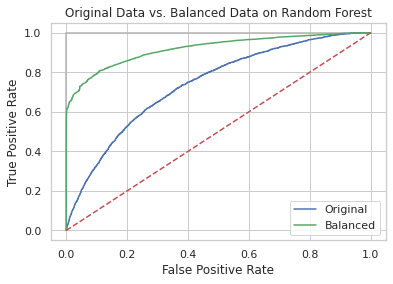

In [31]:
from sklearn.metrics import roc_curve

# Plots the ROC curves
fpr, tpr, threshold = roc_curve(
    y_true=y_test,y_score=y_predict_p_rf)
fpr_smote, tpr_smote, threshold = roc_curve(
    y_true=y_test_smote,y_score=y_predict_p_rf_smote)

plt.title('Original Data vs. Balanced Data on Random Forest')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.plot(fpr, tpr, 'b',label='Original')
plt.plot(fpr_smote, tpr_smote, 'g',label='Balanced')
plt.plot([0, 1], ls="--",c='r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

With a performance increaese like this, it is sufficient to say that balancing the data was very helpful.

### AdaBoost

Remember, from this point on, we're just performing metrics on the balanced dataset (the SMOTE dataset), as clearly the imbalanced dataset is unsatisfactory for our needs.

In [32]:
# Creates model using optimal hyperparameters
ada_model = AdaBoostClassifier(
    learning_rate=ada_best_smote['learning_rate'],
    n_estimators=ada_best_smote['n_estimators']
)

# Fits the model
ada_model.fit(X_train_smote,y_train_smote)

# Predicts using the test set
y_predict_ada = ada_model.predict(X_test_smote)
y_predict_p_ada = ada_model.predict_proba(X_test_smote)[:,1]
# Computes auroc score
auroc_ada = roc_auc_score(y_true=y_test_smote,y_score=y_predict_p_ada)
print('Auroc score: {}'.format(auroc_ada))
# Computes f1 score
f1_ada = f1_score(y_true=y_test_smote,y_pred=y_predict_ada)
print('F1 score: {}'.format(f1_ada))
# Computes accuracy score
acc_ada = accuracy_score(y_true=y_test_smote,y_pred=y_predict_ada)
print('Accuracy: {}'.format(acc_ada))

Auroc score: 0.9453871028476254
F1 score: 0.8860177758508563
Accuracy: 0.8957779980178394


Now to plot the ROC curve...

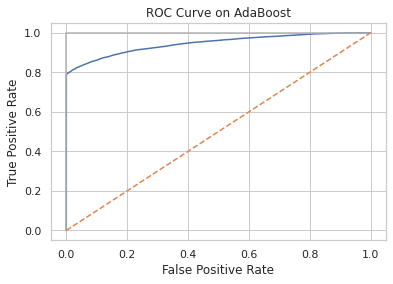

In [33]:
# Plots the ROC curves
ada_fpr, ada_tpr, threshold = roc_curve(
    y_true=y_test_smote,y_score=y_predict_p_ada)

plt.title('ROC Curve on AdaBoost')
plt.plot(ada_fpr, ada_tpr)
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

### XGBoost

Finally, let's see the results on XGBoost.

In [34]:
# Creates model using optimal hyperparameters
xgb_model = XGBClassifier(
    eta=xgb_best_smote['eta'],
    max_depth=xgb_best_smote['max_depth'],
    n_estimators=xgb_best_smote['n_estimators'],
    min_child_weight=xgb_best_smote['min_child_weight'],
)

# Fits the model
xgb_model.fit(X_train_smote,y_train_smote)

# Predicts using the test set
y_predict_xgb = xgb_model.predict(X_test_smote)
y_predict_p_xgb = xgb_model.predict_proba(X_test_smote)[:,1]
# Computes auroc score
auroc_xgb = roc_auc_score(y_true=y_test_smote,y_score=y_predict_p_xgb)
print('Auroc score: {}'.format(auroc_xgb))
# Computes f1 score
f1_xgb = f1_score(y_true=y_test_smote,y_pred=y_predict_xgb)
print('F1 score: {}'.format(f1_xgb))
# Computes accuracy score
acc_xgb = accuracy_score(y_true=y_test_smote,y_pred=y_predict_xgb)
print('Accuracy: {}'.format(acc_xgb))

Auroc score: 0.9536333759024459
F1 score: 0.8895591847287456
Accuracy: 0.898394449950446


... and the ROC Curve...

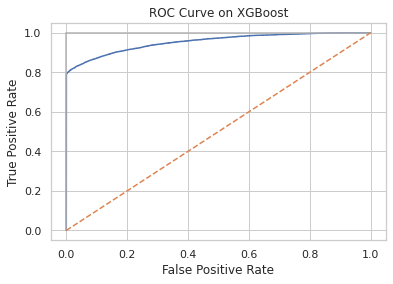

In [35]:
# Plots the ROC curves
xgb_fpr, xgb_tpr, threshold = roc_curve(
    y_true=y_test_smote,y_score=y_predict_p_xgb)

plt.title('ROC Curve on XGBoost')
plt.plot(xgb_fpr, xgb_tpr)
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.plot([0, 1], ls="--")
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Conclusion

When comparing the models, it appears that XGBoost is the best model for learning the data. This is summarized in the following table of evaluation metrics:

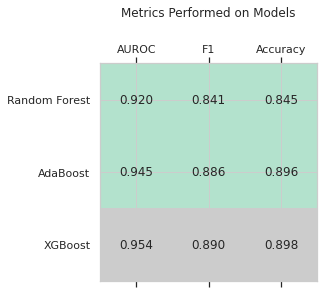

In [36]:
# Creates labels and data
r_labels = ['Random Forest','AdaBoost','XGBoost']
c_labels = ['AUROC','F1','Accuracy']
table = np.array([[auroc_rf_smote,f1_rf_smote,acc_rf_smote],
                  [auroc_ada,f1_ada,acc_ada],
                  [auroc_xgb,f1_xgb,acc_xgb]])

# Creates an undelying table for color hues
best_table = np.zeros(shape=table.shape)
i=0
for val in np.argmax(table,axis=0):
  best_table[val,i] = 1
  i += 1

# Plots the data
fig, ax, = plt.subplots()
ax.matshow(best_table,cmap='Pastel2')
ax.set_yticklabels(['spooky'] + r_labels)
ax.set_xticklabels(['ghost'] + c_labels)
ax.set_title('Metrics Performed on Models\n\n')
# Places metric data inside of matrix
for x in range(table.shape[0]):
  for y in range(table.shape[1]):
    c = '{0:.3f}'.format(table[y,x])
    ax.text(x, y, c, va='center', ha='center')

plt.show()

... and also seen from this zoomed in comparison of the ROC Curves...

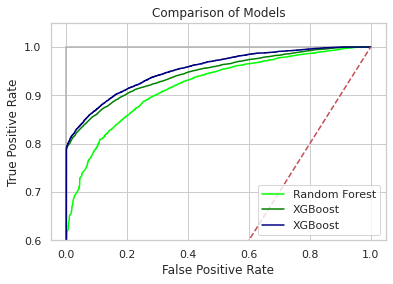

In [37]:
plt.title('Comparison of Models')
plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
plt.plot(fpr_smote, tpr_smote, 'lime',label='Random Forest')
plt.plot(ada_fpr, ada_tpr, 'green',label='XGBoost')
plt.plot(xgb_fpr, xgb_tpr, 'navy',label='XGBoost')
plt.plot([0, 1], ls="--",c='r')
plt.ylim(bottom=0.6)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc='lower right')
plt.show()

XGBoost was suspected to be the most favorable algorithm because of how it uses gradient boosting to create an optimal set of decision trees. The weak learners it produces are very powerful optimizers, so it is no surprise why it did so well.

## Future

One of the major drawbacks to the above models was the lack of variety. Introducing neural networks may provide more favorable results, as well as other types of learners.

For sake of running this notebook in a reasonable time, the meta-parameter `evals` was set to a mere 5 iterations. Bayesian Optimization works better in the 100+ range, so increasing that may produce the best hyperparameters to be used for the models.

One last thing difference that could produce better results is to alter how much SMOTE and Undersampling are done to the data. Overall, these changes serve to make for a much more accurate set of models.

## Citations
[1] J. Brownlee, "SMOTE for Imbalanced Classification with Python", 17-Jan-2020. [Online]. Available: https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/. [Accessed: 06-Dec-2020]

[2] "How to plot a ROC Curve in Python?". [Online]. Available: https://www.dezyre.com/recipes/plot-roc-curve-in-python/. [Accessed:07-Dec-2020]